Here, I'm importing the packages I need initially to start processing the data.

In [2]:

import pandas as pd
import numpy as np
import pyspark
from pyspark import SparkContext
sc =SparkContext()

In [7]:
kdd = pd.read_csv('../desktop/datascience/databases/kdd99.csv')
kdd.shape
#INPUT = '../desktop/datascience/databases/kdd99.csv'

(620097, 30)

After Importing the file, I'm now going to try to break the csv file into lines.

In [3]:

def parse_line(line):
    bits = line.split(",")
    return np.array([float(e) for e in bits[4:12]])

df = sc.textFile(INPUT).map(parse_line)

Initial attempt to take the easy way out and catch outliers more than 2x the standard deviation away from the mean. 

In [4]:
stats = df.map(lambda e: e[0]).stats()
mean, stdev = stats.mean(), stats.stdev()
outliers = df.filter(lambda e: not (mean - 2 * stdev > e[0] > mean + 2 * stdev))
outliers.collect()

[array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  2.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  2.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  3.,  3.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  4.,  4.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  5.,  5.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  6.,  6.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  7.,  7.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  8.,  8.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  2.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  2.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  3.,  3.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  4.,  4.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  5.,  5.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  6.,  6.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  7.,  7.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  8.,  8.]),


Now, Since I've realized that the data isn't normally distributed, trying to use KMeans clustering

In [5]:
from pyspark.mllib.clustering import KMeans
clusters = KMeans.train(df,10, maxIterations=10,
    runs=1, initializationMode="random")

In [6]:
cluster_sizes = df.map(lambda e: clusters.predict(e)).countByValue()

In [7]:

def get_distance(clusters):
    def get_distance_map(record):
        cluster = clusters.predict(record)
        centroid = clusters.centers[cluster]
        dist = np.linalg.norm(record - centroid)
        return (dist, record)
    return get_distance_map

data_distance = df.map(get_distance(clusters))
hist = data_distance.keys().histogram(10)
#print(hist)

In [8]:
x = list(zip(*hist))
print(x)

[(0.041943361033411147, 619672), (46.891030497551569, 251), (93.740117634069733, 37), (140.58920477058788, 58), (187.43829190710605, 38), (234.28737904362421, 28), (281.13646618014235, 0), (327.98555331666051, 0), (374.83464045317868, 0), (421.68372758969684, 14)]


Here I'm converting the data into graphical format for easy understanding

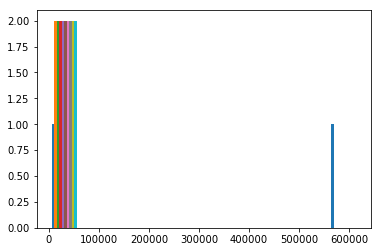

In [83]:
from matplotlib import pyplot as plt
plt.hist(x)
plt.show()

11
11


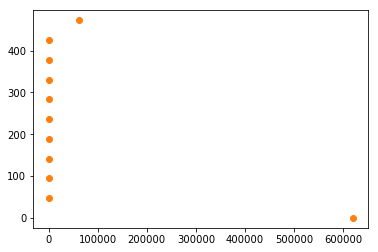

In [86]:

l = hist[1]
l.append(sum(l)/len(l))
print(len(hist[0]))
print(len(hist[1][0:11]))
plt.scatter(hist[1][0:11],hist[0])
plt.show()

# Notice that there is a spike at the end of the histogram. The bars in this histogram represent the clusters and the lenght of the bar represents the number of values lying in each cluster. The spike at the end represents all the outliers being grouped into one cluster by default

Generating random bits of data so that we can create train data for the unsupervised random forest classifier

In [9]:
def unisample(df, fraction=1.0):
    columns = df.first()
    new_df = None
    for i in range(0, len(columns)):
        column = df.sample(withReplacement=True, fraction=fraction)
        df.map(lambda row: row[i])
        df.zipWithIndex()
        df.map(lambda e: (e[1], [e[0]]))
        if new_df is None:
            new_df = column
        else:
            new_df = new_df.join(column)
            new_df = new_df.map(lambda e: (e[0], e[1][0] + e[1][1]))
    return new_df.map(lambda e: e[1])

In [10]:
def supervised2unsupervised(model):
    def run(df, *args, **kwargs):
        unisampled_df = unisample(df)
        unisampled_df = unisample(df)
        labeled_data = df.map(lambda e: LabeledPoint(1, e))
        df.union(unisampled_df.map(lambda e: LabeledPoint(0, e)))
        return model(labeled_data, *args, **kwargs)
    return run

In [ ]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest

unsupervised_forest = supervised2unsupervised(RandomForest.trainClassifier)
rf_model = unsupervised_forest(df, numClasses=2, categoricalFeaturesInfo={},
                  numTrees=75, featureSubsetStrategy="auto",
                  impurity='gini', maxDepth=15, maxBins=50)

In [ ]:
#prediction = df.map(lambda e : rf_model.predict(e))

predictions = rf_model.predict(df.map(lambda x: x.features))
labelsAndPredictions = df.map(lambda lp: lp.label).zip(predictions)
#testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() float(testData.count())
print(rf_model.toDebugString())